In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import torch
from torch.utils.data import DataLoader
device = 'mps'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def train(model, hp, data_loader, debug = False):
    """Train a given model for a specific type of hyperparamters and data_loader, train
    the model and then return the trained model as well as the running losses throughout 
    training.
    
    Parameters
    ----------
    model: torch.nn.Module
        An untrained model to be optimized.
    
    hp: dict
        A dictionary containing all of the hyperparameters for the system.
    
    data_loader: torch.utils.DataLoader
        A presetup dataloader containing the training data set for the set. 
    
    Returns
    -------
    model: torch.nn.Module
        The trained model after optimization.
        
    running_losses: list
        The loss for each epoch of training. 
    """
    
    # Store the losses per epoch
    running_losses = []
    
    # Configure optimizer. 
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"], weight_decay= hp["weight_decay"])

    criterion = torch.nn.MSELoss()
    
    # Outerloop will iterate through epochs. tqdm function trange provides progressbar
    for i in trange(hp["epochs"]):
        
        
        epoch_loss = 0 
        # Inner loop iterates through batches
        for batch in data_loader:

            # Transfer the batch to the GPU
            batch = batch.to(device)

            if debug:
                print("BATCH SHAPE: ")
                print(batch)

            # Zero gradient
            optimizer.zero_grad()

            # Perform forward pass
            pred, code = model(batch)

            # Uncomment to verify model prediction shape
            if debug:
                print("PREDI SHAPE: ")
                print(batch)

            # Compute reconstruction loss
            batch_loss = criterion(pred,batch)

            '''l1_weight = 0.3
            l2_weight = 0.7
      
            # Compute L1 and L2 loss component
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * model.compute_l2_loss(torch.cat(parameters))


            batch_loss += l1
            batch_loss += l2'''
            
            if debug:
                print(batch_loss)

            # Compute gradient
            batch_loss.backward()
            

            # Take step
            optimizer.step()

            # Append to running epoch loss
            epoch_loss += batch_loss.item()

        # Keep running track of losses
        if i % 250 == 0:
            print(f"Epoch [{i}]: " + str(epoch_loss))
    
        running_losses.append(epoch_loss)

    return model, running_losses

In [5]:
X = np.loadtxt("./data/family_data.csv", delimiter = ",")

# 0-1 Normalize the dataset
X = (X - X.min())/(X.max() - X.min())

# Transfer it to torch Tensor
X = torch.Tensor(X)

# Reshape to match the dimensions of the encoder. 
X = X.reshape(( X.shape[0], 1, -1))
print(X.shape)


print(X.type())

torch.Size([9500, 1, 133])
torch.FloatTensor


In [6]:
hp = {
    "in_channels" : 1, # Number of convolutional channels, fixed to 1 for individual curves
    "channels": 10,  # 5 Number of individual channels per layer, increase to boost model capacity
    "depth": 10, # Number of Causal layers in the encoder, increase to boost model capacity
    "reduced_size" : 10, # Size to shrink final embedding to 
    "out_channels" : 10, # ^
    "kernel_size": 3, # Size of convolutional channels, 3 is the smallest to incorporate local information per time point
    "window_length": X.shape[2], # Length of input time series
    "lr": 0.001,  # Learning rate for Adam optimizer
    "epochs": 1000, # Number of training iteractions
    "batch_size": 1000,  # Number of training examples in minibatch descent, maxes at training set size
    "weight_decay":0.5 # Amount of L2 regualirzation for parameters, by default set to zero. 
}

In [8]:
from AE.model.autoencoder import Autoencoder

# Create a new model, increase precision to double floating point precision, transfer to GPU
model = Autoencoder(hp)
model.float()
model.to(device)

in_channels_block=1
in_channels_block=10
in_channels_block=10
in_channels_block=10
in_channels_block=10
in_channels_block=10
in_channels_block=10
in_channels_block=10
in_channels_block=10
in_channels_block=10


/Users/carlosmarinoguera/Documents/IIT/IIT/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Autoencoder(
  (encoder): CausalCNNEncoder(
    (network): Sequential(
      (0): CausalCNN(
        (network): Sequential(
          (0): CausalConvolutionBlock(
            (causal): Sequential(
              (0): Conv1d(1, 10, kernel_size=(3,), stride=(1,), padding=(2,))
              (1): Chomp()
              (2): LeakyReLU(negative_slope=0.01)
              (3): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(2,))
              (4): Chomp()
              (5): LeakyReLU(negative_slope=0.01)
            )
            (residual): Conv1d(1, 10, kernel_size=(1,), stride=(1,))
          )
          (1): CausalConvolutionBlock(
            (causal): Sequential(
              (0): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
              (1): Chomp()
              (2): LeakyReLU(negative_slope=0.01)
              (3): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
              (4): Chomp()
              (5): LeakyReLU(neg

In [116]:

input = torch.randn(1,  1, 133)
#macs, params = profile(model, inputs=(input,))

print(f'{macs=} | {params=}')
# macs=1214388.0 | params=17026.0

NameError: name 'macs' is not defined

In [117]:
data_loader = DataLoader(X, batch_size = hp["batch_size"], )

trained_model, running_losses = train(model, hp, data_loader)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0]: 1.0370610132813454
Epoch [250]: nan


KeyboardInterrupt: 

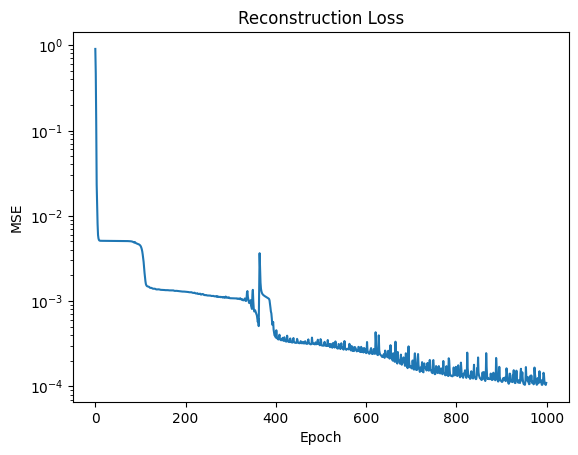

In [103]:

plt.title("Reconstruction Loss")
plt.ylabel("MSE")
plt.yscale('log')
plt.xlabel("Epoch")
plt.plot(running_losses)
plt.show()

In [104]:
# Grab the encoder and decoder
encoder = trained_model.encoder
decoder = trained_model.decoder

# Switch into evaluation mode
encoder.eval()
decoder.eval();


In [105]:
embeddings = encoder(X.to(device)).cpu().detach().numpy();
embeddings.shape

(9500, 10)

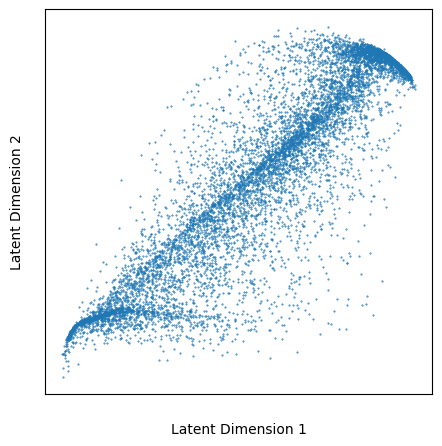

In [106]:
plt.figure(figsize = (5,5))
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left = False,
    right = False, # ticks along the top edge are off
    labelbottom=False,
    labelleft = False,
    zorder = 20) # labels along the bottom edge are off
plt.xlabel("Latent Dimension 1", labelpad= 20)
plt.ylabel("Latent Dimension 2", labelpad = 15)
plt.scatter(embeddings[:,0], embeddings[:,1], s = 0.2)
plt.show()

In [111]:
subset = X[np.random.randint(0,X.shape[0], size = 5), :,:].to(device)

# Generate embeddings and reconstructions
embeddings = model.encoder(subset)
recons = model.decoder(embeddings).cpu().detach()

# Transfer to cpu and drop gradients to enable plotting
embeddings = embeddings.cpu().detach()
subset = subset.cpu().detach()

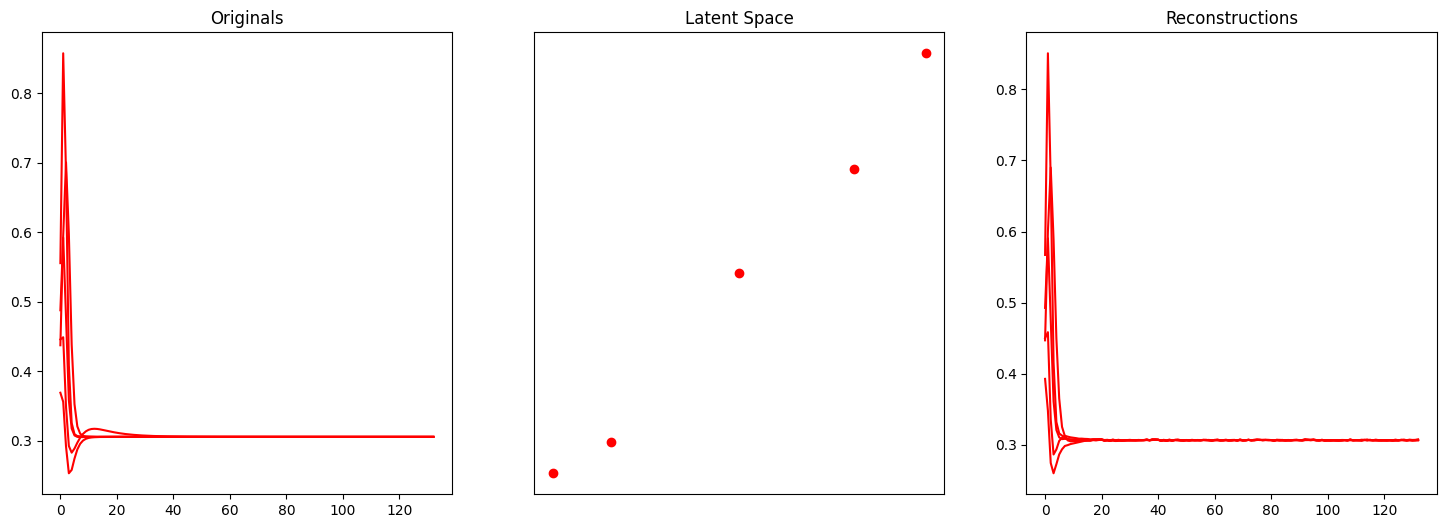

In [112]:
fig, axs = plt.subplots(1,3, figsize = (18,6))
axs = axs.flatten()

axs[0].plot(subset.squeeze().T, color = 'red')
axs[0].set_title("Originals")

axs[1].scatter(embeddings[:,0],embeddings[:,1], color = "red")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Latent Space")

axs[2].plot(recons.squeeze().T, color = 'red')
axs[2].set_title("Reconstructions")

plt.show()

In [113]:
embeddings

tensor([[-1.3636, -1.0769,  1.6314,  0.5806, -0.3112,  0.1327, -0.6973, -0.7556,
          1.5650, -0.9714],
        [-1.0331, -1.0152,  1.3516,  0.6222, -0.2986,  0.0184, -0.5588, -0.7548,
          1.3725, -1.0899],
        [-1.8991, -1.1321,  2.0751,  0.5119, -0.3786,  0.3631, -0.9251, -0.6912,
          1.8811, -0.7166],
        [-2.4890, -1.2221,  2.7404,  0.4626, -0.6829,  0.6267, -1.1392, -0.5153,
          2.2137, -0.3192],
        [-2.7601, -1.2387,  2.8412,  0.4119, -0.5535,  0.7345, -1.2856, -0.5576,
          2.3817, -0.2890]])